# Objective:
find and remove pixels for compression where the same output on denoising in decompression is guaranteed

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import numpy as np
import cv2
import sys
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

np.set_printoptions(threshold=sys.maxsize)

import os
import pickle
import zlib

# Experiment

TODO:Autoadjusting mask size by image ratio

TODO: System that would try many combinations to get the highest compression with lowest data loss by the two hyprparameters

some conclusions: storing the extended compressed version, will disturb the default compression algorithm of the extension and create a larger image than the original.
so: this method is best for just use in transfer(compressed state)

In [13]:
def all_elements_equal(array, threshold):
    array = np.array(array, dtype=np.float64)
    # np.minimum()
    # Get the first element of the array
    first_element = array[0][0]

    # Compare each element with the first element
    for row in array:
        for element in row:
            if abs(element - first_element) > threshold:
                return False
    return True

def surrounding_elements_equal(array):
  # Determine the central position
  central_position = (array.shape[0] // 2, array.shape[1] // 2)
  central_value = array[central_position]
  
  # Iterate over the array and compare elements, skipping the central element
  for i in range(array.shape[0]):
      for j in range(array.shape[1]):
          # Skip the central element
          if (i, j) == central_position:
              continue
          
          # Check if the current element is different from the first non-central element
          if array[i, j] != array[0, 0] or array[0, 0] == central_value:
              # If the first element is the same as the central value or
              # if any surrounding element is different, return False
              return False
  
  # If all surrounding elements are the same and not equal to the central value, return True
  return True


def local_compression(original_values, mask_size, threshold):
  if all_elements_equal(original_values, threshold) == True:
    the_centeral_value = original_values[0][0]
    
    # Create a zeros array of the target size
    array = np.zeros_like(original_values, dtype=type(the_centeral_value))
    
    # Calculate the central position
    central_position = (mask_size // 2, mask_size // 2)
    
    # Set the central position to the central_value
    array[central_position] = the_centeral_value
    return array
  else: return original_values

def local_decompression(original_values, mask_size):
  if surrounding_elements_equal(original_values) == True:
      central_position = (mask_size // 2, mask_size // 2)
      return np.full(mask_size, original_values[central_position], dtype=original_values.dtype)
  else: return original_values




def compress(image_array, mask_size=3, threshold=0):
  filtered_array = np.zeros_like(image_array)

  for i in range(0, image_array.shape[0] - mask_size + 1, mask_size):
    for j in range(0, image_array.shape[1] - mask_size + 1, mask_size):
      window = image_array[i:i+mask_size, j:j+mask_size]
      filtered_array[i:i+mask_size, j:j+mask_size] = local_compression(window, mask_size, threshold)
  
  return filtered_array


def decompress(image_array, mask_size=3):
  filtered_array = np.zeros_like(image_array)

  for i in range(0, image_array.shape[0] - mask_size + 1, mask_size):
    for j in range(0, image_array.shape[1] - mask_size + 1, mask_size):
      window = image_array[i:i+mask_size, j:j+mask_size]
      filtered_array[i:i+mask_size, j:j+mask_size] = local_decompression(window, mask_size)

  return filtered_array

In [31]:
def resolution_comparison(original_array, compressed_array):
  # Convert images to numpy arrays
  # original_array = np.array(original_image)
  # compressed_array = np.array(compressed_image)

  # Calculate PSNR and SSIM
  psnr_value = psnr(original_array, compressed_array, data_range=compressed_array.max() - compressed_array.min())
  ssim_value = ssim(original_array, compressed_array, multichannel=True)

  print(f"PSNR: {psnr_value}")
  print(f"SSIM: {ssim_value}")

## A little demonstration

In [14]:
image_array = np.array([
  [2, 2, 2, 2, 2, 2],
  [3, 2, 2, 2, 2, 2],
  [2, 2, 2, 2, 2, 2],
  [2, 2, 2, 2, 2, 2],
  [2, 2, 2, 2, 2, 2],
  [2, 2, 2, 2, 2, 2],
])

print('no threshold')
compressed = compress(image_array, 3, 0)
print(compressed)

print('decompression')
decompressed = decompress(compressed, 3)
print(decompressed)

print('some threshold')
compressed = compress(image_array, 3, 1)
print(compressed)

print('decompression')
decompressed = decompress(compressed, 3)
print(decompressed)

no threshold
[[2 2 2 0 0 0]
 [3 2 2 0 2 0]
 [2 2 2 0 0 0]
 [0 0 0 0 0 0]
 [0 2 0 0 2 0]
 [0 0 0 0 0 0]]
decompression
[[2 2 2 2 2 2]
 [3 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]]
some threshold
[[0 0 0 0 0 0]
 [0 2 0 0 2 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 2 0 0 2 0]
 [0 0 0 0 0 0]]
decompression
[[2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]]


# Try on Real Image

In [35]:
def resolution_comparison(original_array, compressed_array):
  # Calculate PSNR and SSIM
  psnr_value = psnr(original_array, compressed_array, data_range=compressed_array.max() - compressed_array.min())
  ssim_value = ssim(original_array, compressed_array, multichannel=True)

  # A high PSNR value suggests minor differences between the original and compressed images, indicating less resolution loss.
  # A SSIM value close to 1 indicates a high similarity between the two images, suggesting the compression has preserved structural and perceptual features well.
  
  print(f"PSNR: {psnr_value}")
  print(f"SSIM: {ssim_value}")

In [15]:
def store_image(img_array, path):
  image_from_arr = Image.fromarray(img_array)
  image_from_arr.save(path)

In [16]:
def normal_compression_process(img_array):
  # return pickle.dumps(img_array)
  # print(len(img_array))
  serialized_image = pickle.dumps(img_array)
  # print(len(serialized_image))
  compressed_serialized_image = zlib.compress(serialized_image, -1)
  # print(len(compressed_serialized_image))
  return compressed_serialized_image

def normal_decompression_process(compressed_serialized_image):
  # return pickle.loads(compressed_serialized_image)
  # print(len(compressed_serialized_image))
  serialized_image = zlib.decompress(compressed_serialized_image)
  # print(len(serialized_image))
  image_array = pickle.loads(serialized_image)
  # print(len(image_array))
  return image_array


In [38]:
def normal_and_extended_compression(original_image_array, mask_size, threshold):
  # The normal compression
  compressed_serialized_image = normal_compression_process(original_image_array)
  decompressed_serialized_image = normal_decompression_process(compressed_serialized_image)
  
  # The extended compression
  compressed_extended_array = compress(original_image_array, mask_size, threshold)
  compressed_extended_serialized_image = normal_compression_process(compressed_extended_array)
  extended_decompressed_serialized_image = normal_decompression_process(compressed_extended_serialized_image)
  extended_decompressed = decompress(extended_decompressed_serialized_image, mask_size)
  resolution_comparison(original_image_array, extended_decompressed)

  # results
  print('\noriginal', len(pickle.dumps(original_image_array)))
  print('normal compression', len(compressed_serialized_image))
  print('extended compression', len(compressed_extended_serialized_image))
  print('size difference:', len(compressed_serialized_image)-len(compressed_extended_serialized_image))
  
  # store_image(decompressed_serialized_image, './normal_decompression-'+str(mask_size)+'-'+str(threshold)+'.png')
  # store_image(extended_decompressed, './extended_decompression-'+str(mask_size)+'-'+str(threshold)+'.png')
  # store_image(compressed_extended_array, './extended_compression-'+str(mask_size)+'-'+str(threshold)+'.png')

  # Display the original and decompressed images
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  ax[0].imshow(compressed_extended_array, cmap='gray')
  ax[0].set_title('compressed extended')
  ax[1].imshow(extended_decompressed, cmap='gray')
  ax[1].set_title('extended decompressed')
  plt.show()

### original gray scaled

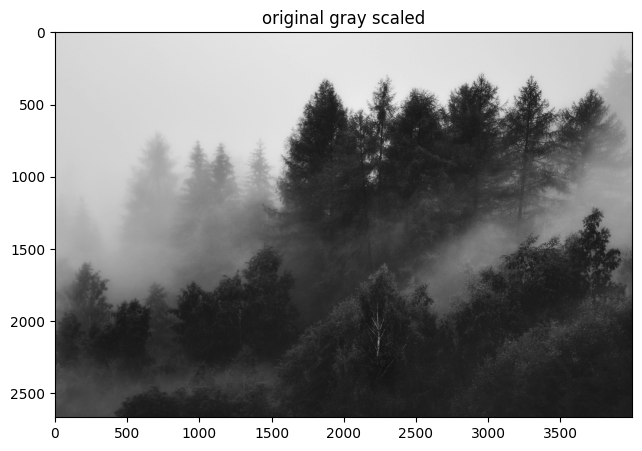

In [19]:
# Step 1: Open the image
image = Image.open('./assets/pexels-eberhard-grossgasteiger-1367192.jpg')

# Step 2: Convert the image to a NumPy array
image_array = np.array(image)

# Convert to grayscale by averaging the RGB values
grayscale_array = image_array.mean(axis=-1).astype(np.uint8)

# store_image(grayscale_array, './original-grayscaled.png')

# Display the original and decompressed images
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(grayscale_array, cmap='gray')
ax.set_title('original gray scaled')
plt.show()

### not good:
just masking off

PSNR: 40.32496434428906
SSIM: 0.9992004804995912

original 10664163
normal compression 4748828
extended compression 4988114
size difference: -239286


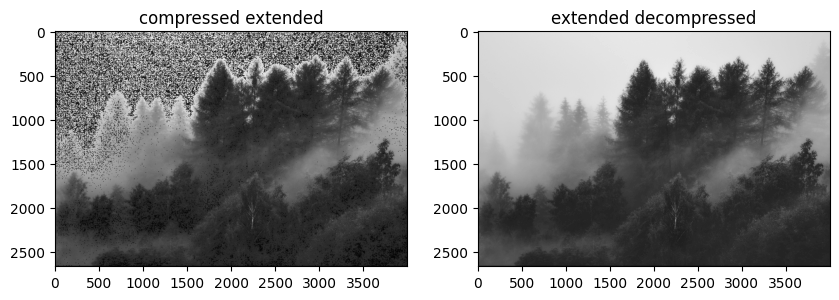

In [39]:
normal_and_extended_compression(grayscale_array, 3, 0)

### starting to get some compression with a smallest possible threshold and mask size

PSNR: 55.458211106204296
SSIM: 0.9982639748004387

original 10664163
normal compression 4748828
extended compression 4685303
size difference: 63525


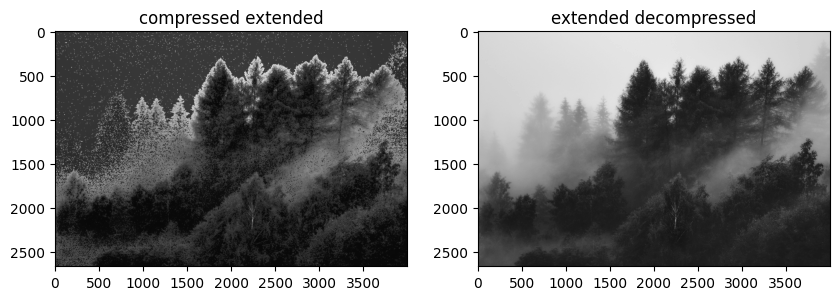

In [40]:
normal_and_extended_compression(grayscale_array, 2, 1)

PSNR: 27.66592687215101
SSIM: 0.987301213806308

original 10664163
normal compression 4748828
extended compression 4712756
size difference: 36072


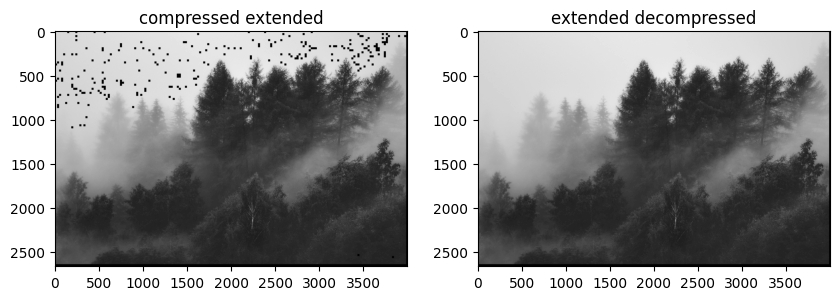

In [41]:
normal_and_extended_compression(grayscale_array, 23, 1)

PSNR: 26.19993461225127
SSIM: 0.9852380366891273

original 10664163
normal compression 4748828
extended compression 4701275
size difference: 47553


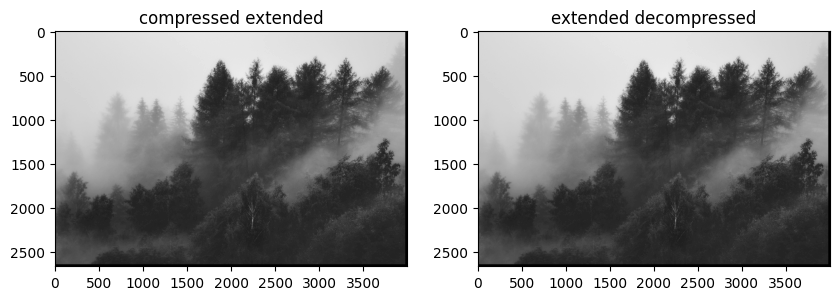

In [42]:
normal_and_extended_compression(grayscale_array, 63, 1)

PSNR: 24.023764197210127
SSIM: 0.7926679011749616

original 10664163
normal compression 4748828
extended compression 69920
size difference: 4678908


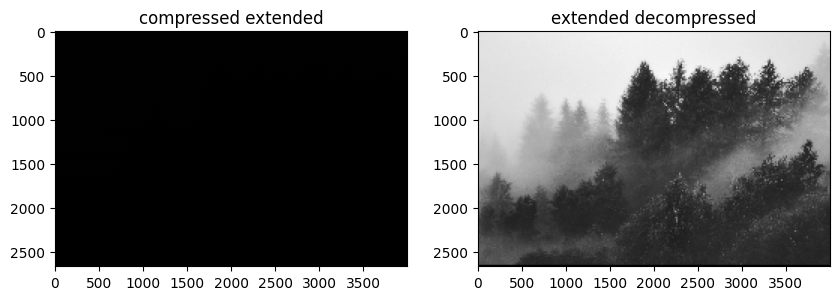

In [43]:
normal_and_extended_compression(grayscale_array, 17, 900)

PSNR: 25.78455478835035
SSIM: 0.7920485377824993

original 10664163
normal compression 4748828
extended compression 253952
size difference: 4494876


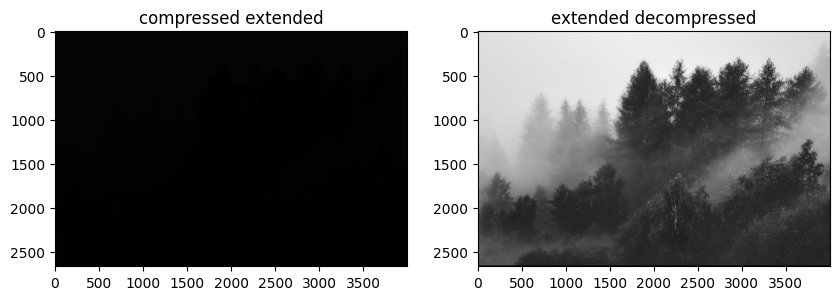

In [44]:
normal_and_extended_compression(grayscale_array, 7, 900)

PSNR: 25.78455478835035
SSIM: 0.7920485377824993

original 10664163
normal compression 4748828
extended compression 253952
size difference: 4494876


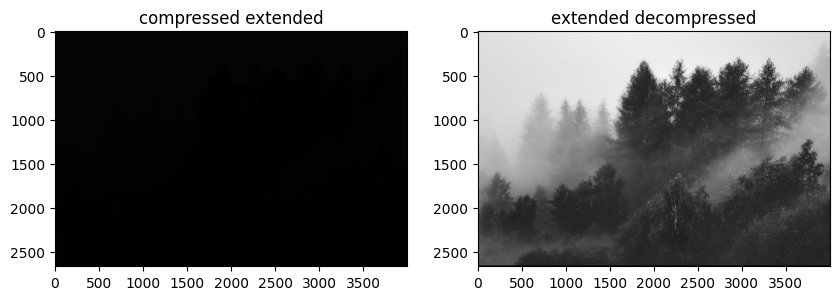

In [45]:
normal_and_extended_compression(grayscale_array, 7, 300)

PSNR: 35.021443822159235
SSIM: 0.9093717177004097

original 10664163
normal compression 4748828
extended compression 1701359
size difference: 3047469


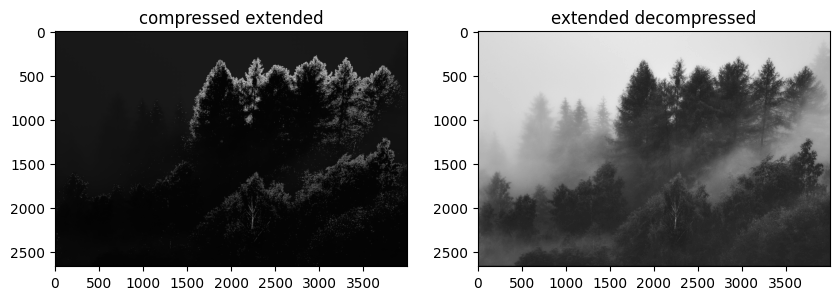

PSNR: 30.51207203927108
SSIM: 0.8631590376218934

original 10664163
normal compression 4748828
extended compression 1053928
size difference: 3694900


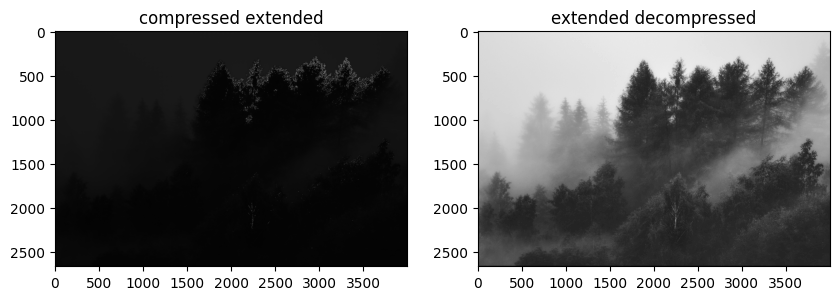

In [46]:
normal_and_extended_compression(grayscale_array, 3, 20)
normal_and_extended_compression(grayscale_array, 3, 70)

PSNR: 37.44625274265672
SSIM: 0.9493045056865286

original 10664163
normal compression 4748828
extended compression 2151470
size difference: 2597358


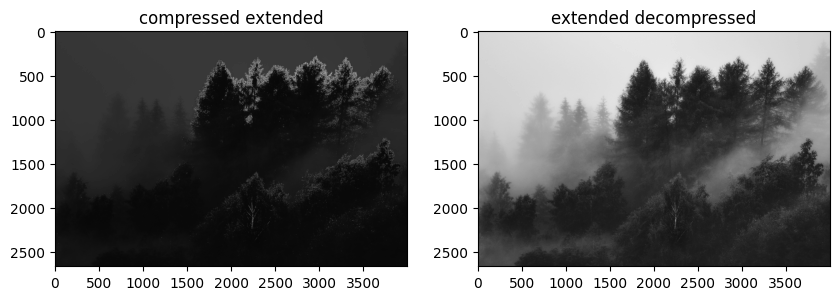

PSNR: 32.74625640906906
SSIM: 0.9326211410987485

original 10664163
normal compression 4748828
extended compression 1845238
size difference: 2903590


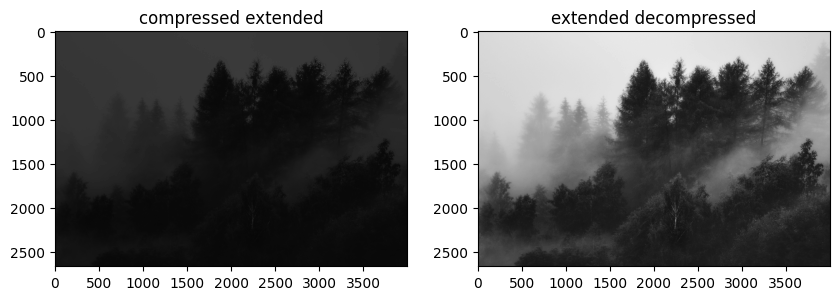

In [47]:
normal_and_extended_compression(grayscale_array, 2, 20)
normal_and_extended_compression(grayscale_array, 2, 70)

PSNR: 45.22281876751693
SSIM: 0.9846865316199347

original 10664163
normal compression 4748828
extended compression 3317414
size difference: 1431414


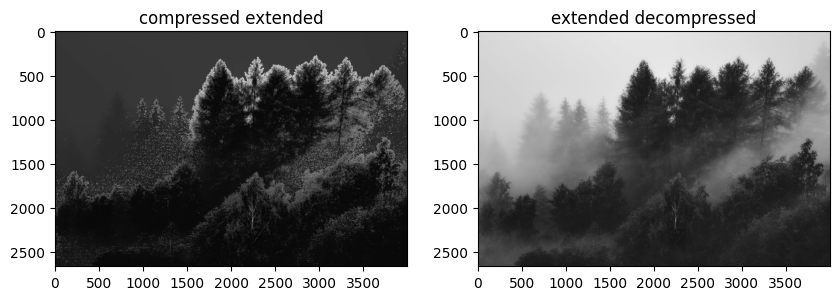

In [48]:
normal_and_extended_compression(grayscale_array, 2, 5)

PSNR: 18.778414373822166
SSIM: 0.7746557233464544

original 10664163
normal compression 4748828
extended compression 15980
size difference: 4732848


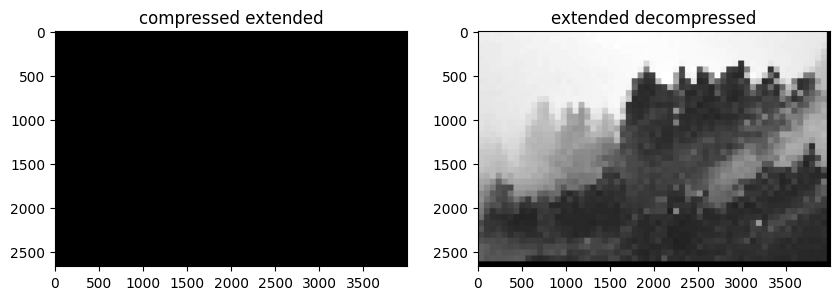

In [49]:
normal_and_extended_compression(grayscale_array, 67, 300)

PSNR: 34.89599198505915
SSIM: 0.9916648501270662

original 10664163
normal compression 4748828
extended compression 4217769
size difference: 531059


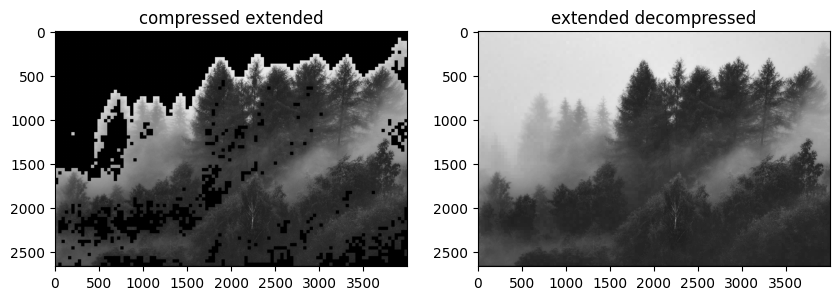

In [50]:
normal_and_extended_compression(grayscale_array, 37, 10)

PSNR: 25.74758169774592
SSIM: 0.9687316905988116

original 10664163
normal compression 4748828
extended compression 4466500
size difference: 282328


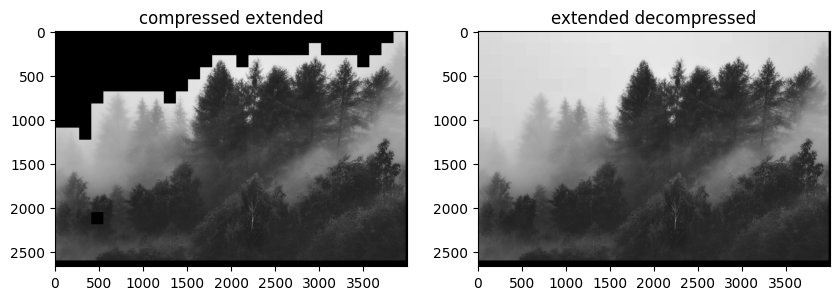

In [51]:
normal_and_extended_compression(grayscale_array, 137, 10)

## hyperparameters and compression chart

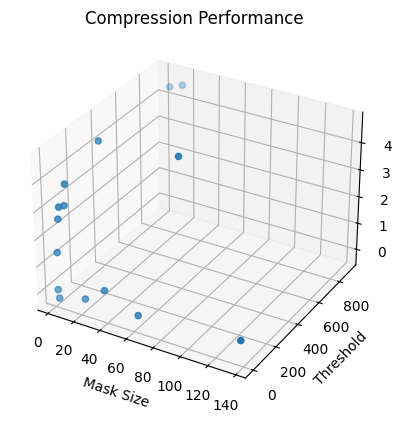

In [52]:
# 3, 0 -239286
# 2, 1 63525
# 23, 1 36072
# 63, 1 47553
# 17, 900 4678908
# 7, 900 4494876
# 7, 300 4494876
# 3, 20 3047469
# 3, 70 3694900
# 2, 20 2597358
# 2, 70 2903590
# 2, 5 1431414
# 67, 300 4732848
# 37, 10 531059
# 137, 10 282328


# Sample data: hyperparameter1, hyperparameter2, and result
hyperparameter1 = np.array([
  3,
  2,
  23,
  63,
  17,
  7,
  7,
  3,
  3,
  2,
  2,
  2,
  67,
  37,
  137
])  # For example, compression level
hyperparameter2 = np.array([
  0,
  1,
  1,
  1,
  900,
  900,
  300,
  20,
  70,
  20,
  70,
  5,
  300,
  10,
  10,
])   # For example, block size
result = np.array([
  -239286,
  63525,
  36072,
  47553,
  4678908,
  4494876,
  4494876,
  3047469,
  3694900,
  2597358,
  2903590,
  1431414,
  4732848,
  531059,
  282328,
])  # Sample result, replace with your actual data

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(hyperparameter1, hyperparameter2, result)

# Labeling the axes
ax.set_xlabel('Mask Size')
ax.set_ylabel('Threshold')
ax.set_zlabel('compression')

# Title
ax.set_title('Compression Performance')

plt.show()

# Generate a mask based on the image shape
#### not done!

In [53]:
print(grayscale_array.shape)
scale = .02
ratio = grayscale_array.shape[1]/grayscale_array.shape[0]
mask_height = int(scale*grayscale_array.shape[0])
mask_width = int(mask_height*ratio)
print(mask_height, mask_width)

(2666, 4000)
53 79
